In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
#plt.style.use('seaborn')
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances



In [190]:
BostMar_df = pd.read_csv('C:/Users/keith/Desktop/Thinkful/results.txt',encoding = "ISO-8859-1",error_bad_lines=False)
pd.set_option('display.max_columns', 50)

In [191]:
BostMar_df.head()

,division,name,city,gender,age,official,bib,overall,state,genderdiv,net,country
0,4 / 26,"Soejima, Masazumi",Fukuoka City,M,41,83.45,W1,4 / 35,NaN,4 / 26,83.45,JPN
1,14 / 4335,"Gebremariam, Gebregziabher",Tigray,M,27,142.93,2,14 / 21616,NaN,14 / 12621,142.93,ETH
2,6 / 26,"Van Dyk, Ernst F.",Paarl,M,39,84.38,W2,6 / 35,NaN,6 / 26,84.38,RSA
3,2 / 26,"Fearnley, Kurt H.",Hamilton,M,31,81.65,W3,2 / 35,NaN,2 / 26,81.65,AUS
4,3 / 26,"Hokinoue, Kota",Iizuka,M,38,83.43,W4,3 / 35,NaN,3 / 26,83.43,JPN


In [192]:
BostMar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21652 entries, 0 to 21651
Data columns (total 12 columns):
division     21652 non-null object
name         21652 non-null object
city         21652 non-null object
gender       21652 non-null object
age          21652 non-null int64
official     21652 non-null object
bib          21652 non-null object
overall      21652 non-null object
state        19880 non-null object
genderdiv    21652 non-null object
net          21652 non-null float64
country      21652 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 2.0+ MB


In [193]:
BostMar_df.duplicated().sum()


0

In [194]:
# check for null values
BostMar_df.isna().sum()

division        0
name            0
city            0
gender          0
age             0
official        0
bib             0
overall         0
state        1772
genderdiv       0
net             0
country         0
dtype: int64

In [195]:
# drop columns not being used
BostMar_df = BostMar_df.drop(['state','name','city','overall','genderdiv'],1)
BostMar_df.head()

,division,gender,age,official,bib,net,country
0,4 / 26,M,41,83.45,W1,83.45,JPN
1,14 / 4335,M,27,142.93,2,142.93,ETH
2,6 / 26,M,39,84.38,W2,84.38,RSA
3,2 / 26,M,31,81.65,W3,81.65,AUS
4,3 / 26,M,38,83.43,W4,83.43,JPN


In [196]:
# drop rows that have "-" and convert "official" to a float
BostMar_df.drop(list(np.where(BostMar_df.official=='-')[0]),0,inplace=True)
BostMar_df.index = range(len(BostMar_df))
BostMar_df['official'] = BostMar_df.official.astype(float)

Here we'll take a look at distributions of the continuous variables

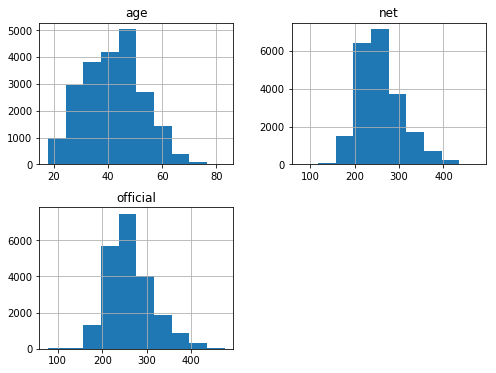

In [197]:
BostMar_df.hist(figsize=(8,6))
plt.show()

In [198]:
BostMar_df.describe()

,age,official,net
count,21576.000000,21576.000000,21576.000000
mean,41.829672,262.798014,258.159473
std,10.849432,50.383191,49.017446
min,18.000000,78.420000,78.420000
25%,33.000000,228.645000,224.577500
50%,42.000000,255.720000,250.950000
75%,50.000000,290.630000,285.135000
max,83.000000,475.320000,475.250000


After some research net time is the true time of the runner so we'll drop the official columns as well since it is redundant. 

In [199]:
BostMar_df.drop('official',1,inplace=True)

In [200]:
BostMar_df.describe(include='object')

,division,gender,bib,country
count,21576,21576,21576,21576
unique,21576,2,21576,60
top,1746 / 4335,M,2212,USA
freq,1,12608,1,17993


In [201]:
# create a binary feature for gender
BostMar_df['gender_bin'] = np.where(BostMar_df.gender=='M',1,0)
BostMar_df.gender_bin.value_counts()

1    12608
0     8968
Name: gender_bin, dtype: int64

Now, let's compare some features

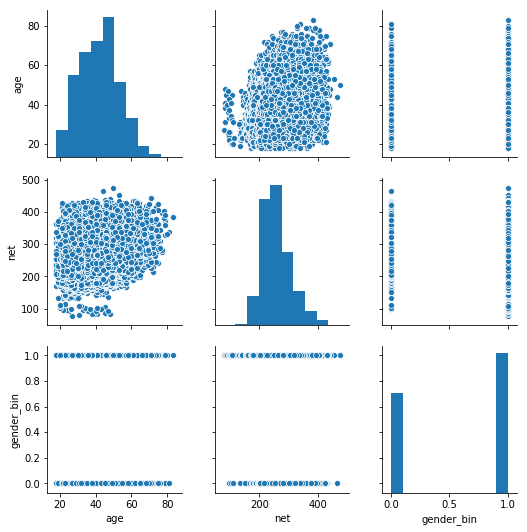

In [202]:
sns.pairplot(BostMar_df)
plt.show()

In [203]:
men_df = BostMar_df[BostMar_df.gender=='M']
women_df = BostMar_df[BostMar_df.gender=='F']

Not really a lot to gather from the pairplot.

In [204]:
BostMar_df.groupby('gender').net.describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,8968.0,269.635854,44.906056,97.60,238.045,261.370,293.3725,465.42
M,12608.0,249.996386,50.172016,78.42,214.945,240.815,278.1000,475.25


In [205]:
BostMar_df.groupby('gender').age.describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,8968.0,39.145963,10.039411,18.0,31.0,39.0,46.0,81.0
M,12608.0,43.738579,10.999406,18.0,36.0,44.0,51.0,83.0


I don't think it is very surprising to see that the men times are on average faster that the women times but it is interesting that the average time aren't very far apart. Also, the longest time ran was a man. The women also younger in age than the men.

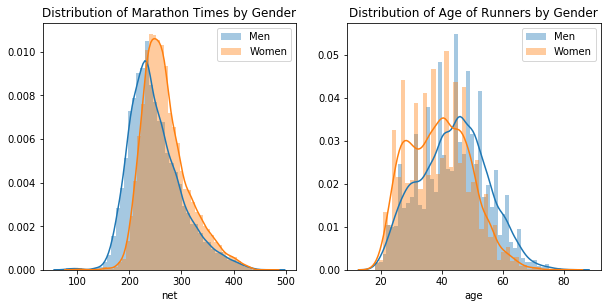

In [206]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.distplot(BostMar_df[BostMar_df.gender=='M'].net,label="Men")
sns.distplot(BostMar_df[BostMar_df.gender=='F'].net,label="Women")
plt.title('Distribution of Marathon Times by Gender')
plt.legend()
 
plt.subplot(222)
sns.distplot(BostMar_df[BostMar_df.gender=='M'].age,label="Men")
sns.distplot(BostMar_df[BostMar_df.gender=='F'].age,label="Women")
plt.title('Distribution of Age of Runners by Gender')
plt.legend()
plt.show()


The distributions of the net times for men and women both resemble a normal distribution. The men's distibution is just shifted to the left a slight bit more that the womens which is what we saw in the statistics. In contrast the age of the of the women is shifted slightly to the left.
We also need to be aware that there are times from wheelchair compeditors that have much faster times that some of the runners. Normally I would drop these columns because it could skew the analysis but I want to see how the clustering algoritims handle the data with those times inculded.

In [207]:
# top 30 fastest countries
BostMar_df.groupby('country').net.mean().sort_values()[:30] 

country
KEN    142.776667
ETH    153.346667
CRC    210.840000
CZE    213.120000
RUS    220.977143
DOM    221.315000
CHN    223.480000
GRE    223.925000
NGR    224.050000
UAE    225.323333
MLT    225.970000
ECU    228.081667
COL    229.638929
ISL    231.875455
NOR    231.931667
NZL    232.570667
VEN    233.707500
PHI    235.170000
CAY    235.490000
FIN    235.800833
SWE    237.505312
SLO    241.611429
ISR    241.850000
AUS    242.105890
MAS    242.292000
ARG    242.796154
AUT    242.996471
MEX    243.946101
SUI    244.041739
HUN    244.870000
Name: net, dtype: float64

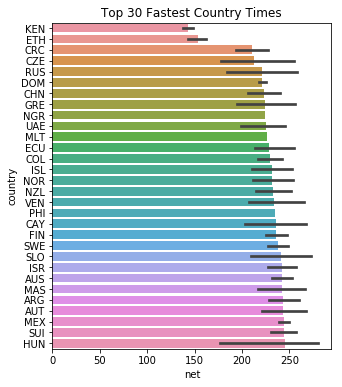

In [208]:
order = BostMar_df.groupby('country').net.mean().sort_values(ascending=True).index[:30]
plt.figure(figsize=(5,6))
sns.barplot(BostMar_df.net,BostMar_df.country, order=order)
plt.title('Top 30 Fastest Country Times')
plt.show()

Here I will create a few new features

In [209]:
# bin ages by how ages are grouped in the marathon
bins = [13,19,24,29,34,39,44,49,54,59,64,70,74,79,200]
BostMar_df['age_grp'] = pd.cut(BostMar_df.age,bins,labels=range(1,15,1))
BostMar_df.age_grp.value_counts()

7     3687
6     3539
5     3022
8     2682
4     2515
3     2394
9     1473
2      946
10     849
11     330
12      57
1       50
13      29
14       3
Name: age_grp, dtype: int64

In [211]:
# separate placing and divisions
BostMar_df['place_in_division'] = BostMar_df.division.str.replace(" ","").str.split('/').apply(lambda x: x[0])
BostMar_df['divisions'] = BostMar_df.division.str.replace(" ","").str.split('/').apply(lambda x: x[1])

In [212]:
# indicator variable of wheelchair participants
BostMar_df['WC_part'] = np.where((BostMar_df.bib.str.contains('W'))|(BostMar_df.bib.str.contains("F")),1,0)

In [213]:
# average pace of competitor
BostMar_df['avg_pace'] = BostMar_df.net/26.219

In [214]:
#label countries by rank
rank = BostMar_df.groupby('country').net.mean().rank().to_dict()
BostMar_df['country_rank'] = BostMar_df.country.map(rank)

In [220]:
X.columns

Index(['age', 'net', 'gender_bin', 'avg_pace', 'divisions_1080',
       'divisions_14', 'divisions_1442', 'divisions_1521', 'divisions_165',
       'divisions_1881', 'divisions_19', 'divisions_2', 'divisions_2019',
       'divisions_2255', 'divisions_26', 'divisions_262', 'divisions_27',
       'divisions_3', 'divisions_398', 'divisions_4335', 'divisions_45',
       'divisions_4599', 'divisions_688', 'divisions_72', 'divisions_807',
       'divisions_9'],
      dtype='object')

In [219]:
# Break into a set of features and a variable for the known outcome.

BM_df = BostMar_df[['division', 'gender', 'age', 'bib', 'net', 'country', 'gender_bin',
       'age_grp', 'place_in_division', 'divisions', 'WC_part', 'avg_pace',
       'country_rank']]  

BM_df = pd.get_dummies(BM_df.drop(['division','age_grp','place_in_division', 'country_rank','gender','bib','country','WC_part'],1),drop_first=True)

X = BM_df 
y = BostMar_df.gender_bin 


# normalize data
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()
DATA = pd.DataFrame()
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2,yh1,yh2 = train_test_split(
    X_norm,
    X_pca,
    y,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2,y1,y2 = train_test_split(
    X_half1,
    X_pcahalf1,
    yh1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4,y3,y4 = train_test_split(
    X_half2,
    X_pcahalf2,
    yh2,
    test_size=0.5,
    random_state=42)
 
Allsamps_df = pd.concat([pd.DataFrame(X1,),pd.DataFrame(X2),pd.DataFrame(X3),pd.DataFrame(X4)],axis=1)

In [221]:
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 6):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
         

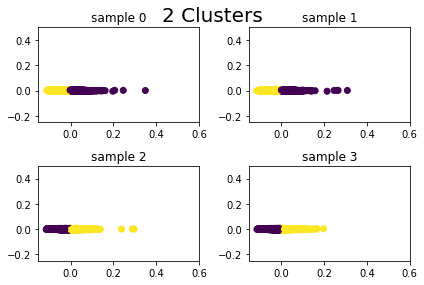

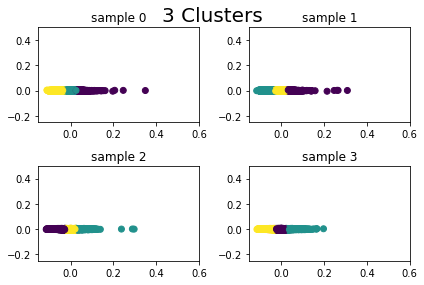

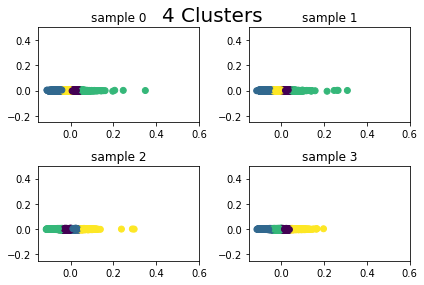

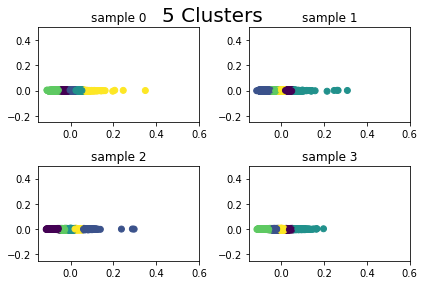

In [222]:
for cluster in range(2, 6):
     
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        #print(x_sub)
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.15, .60])
        axarr[rows, cols].set_ylim([-.25, .50])
       
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [158]:
for q in np.arange(.8,1,.1):
    bandwidth = estimate_bandwidth(X_norm, quantile=q, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X_norm)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    print("Number of estimated clusters: {}".format(n_clusters_))
    for sample in [X1, X2, X3, X4]:
        model = KMeans(n_clusters=2, random_state=42).fit(sample)
        labels = model.labels_
        print(metrics.silhouette_score(sample, labels, metric='euclidean'))

Number of estimated clusters: 2
0.5673240609013439
0.5608117313883892
0.5620974690902706
0.5583899554172471
Number of estimated clusters: 1
0.5673240609013439
0.5608117313883892
0.5620974690902706
0.5583899554172471


In [228]:
Final_df=pd.DataFrame()
Final_df['clusters']= KMeans(n_clusters=3, random_state=42).fit_predict(X_norm)
Final_df = pd.concat([ BostMar_df[['division', 'gender', 'age', 'bib', 'net', 'country', 'gender_bin',
       'age_grp', 'place_in_division', 'divisions', 'WC_part', 'avg_pace',
       'country_rank']] ,Final_df],axis=1)

In [229]:
Final_df['pca1'] = pca.fit_transform(X_norm)[:,0]
Final_df['pca2'] = pca.fit_transform(X_norm)[:,1]

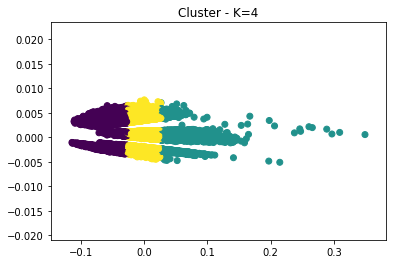

In [230]:
Final_df
plt.scatter(Final_df.pca1,Final_df.pca2,c=Final_df.clusters)
plt.title('Cluster - K=4')
plt.show()

In [231]:
Final_df.head()

,division,gender,age,bib,net,country,gender_bin,age_grp,place_in_division,divisions,WC_part,avg_pace,country_rank,clusters,pca1,pca2
0,4 / 26,M,41,W1,83.45,JPN,1,6,4,26,1,3.182806,49.0,1,0.288622,0.001694
1,14 / 4335,M,27,2,142.93,ETH,1,3,14,4335,0,5.451390,2.0,2,0.022853,0.006631
2,6 / 26,M,39,W2,84.38,RSA,1,5,6,26,1,3.218277,32.0,1,0.265833,0.002010
3,2 / 26,M,31,W3,81.65,AUS,1,4,2,26,1,3.114154,24.0,1,0.197706,0.003463
4,3 / 26,M,38,W4,83.43,JPN,1,5,3,26,1,3.182044,49.0,1,0.260479,0.002193


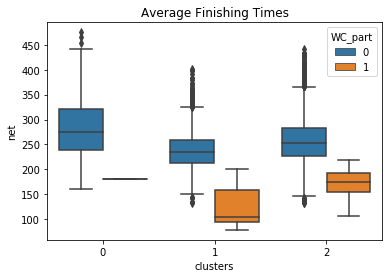

In [232]:
sns.boxplot(Final_df.clusters,Final_df.net, hue=Final_df.WC_part)
plt.title('Average Finishing Times')
plt.show()

In [173]:
Final_df.head()

,gender,age,net,country,avg_pace,place_in_division,divisions,age_grp,clusters,pca1,pca2
0,M,41,83.45,JPN,3.182806,4,26,6,1,0.288692,0.008535
1,M,27,142.93,ETH,5.451390,14,4335,3,1,0.022911,0.003897
2,M,39,84.38,RSA,3.218277,6,26,5,1,0.265895,0.008052
3,M,31,81.65,AUS,3.114154,2,26,4,1,0.197746,0.007771
4,M,38,83.43,JPN,3.182044,3,26,5,1,0.260539,0.008099


Text(0.5, 1.0, 'Cluster4')

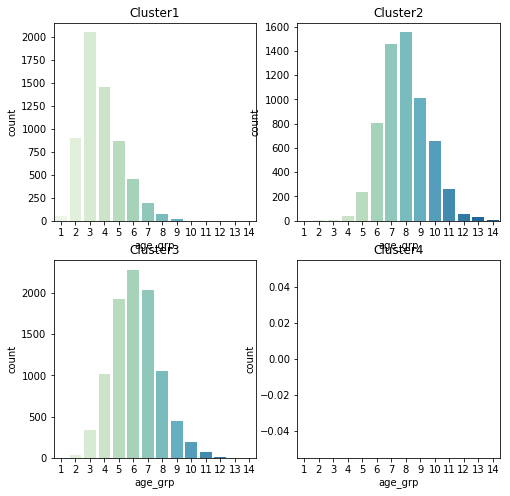

In [233]:
Cluster1 = Final_df[Final_df.clusters==0]
Cluster2 = Final_df[Final_df.clusters==1]
Cluster3 = Final_df[Final_df.clusters==2]
Cluster4 = Final_df[Final_df.clusters==3]





plt.figure(figsize=(8,8))
plt.subplot(221)
sns.countplot(Cluster1.age_grp,palette='GnBu')
plt.title('Cluster1')
plt.subplot(222)
sns.countplot(Cluster2.age_grp,palette='GnBu')
plt.title('Cluster2')
plt.subplot(223)
sns.countplot(Cluster3.age_grp,palette='GnBu')
plt.title('Cluster3')
plt.subplot(224)
sns.countplot(Cluster4.age_grp,palette='GnBu')
plt.title('Cluster4')

Text(0.5, 1.0, 'Cluster4')

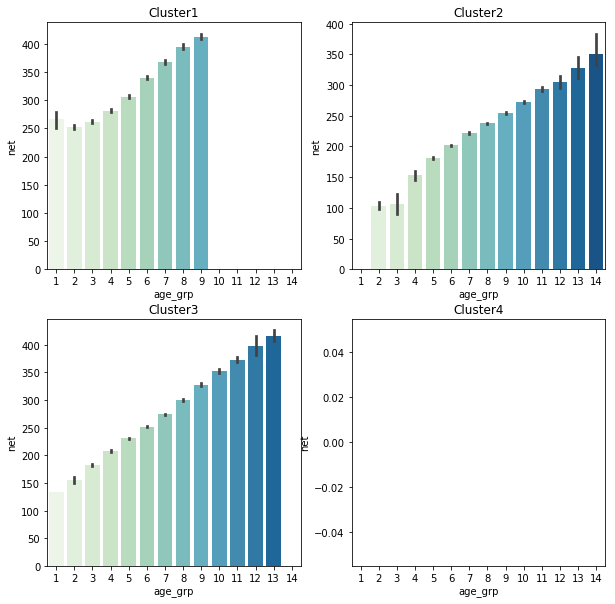

In [234]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.barplot(Cluster1.age_grp,Cluster1.net,palette='GnBu')
plt.title('Cluster1')
plt.subplot(222)
sns.barplot(Cluster2.age_grp,Cluster2.net,palette='GnBu')
plt.title('Cluster2')
plt.subplot(223)
sns.barplot(Cluster3.age_grp,Cluster3.net,palette='GnBu')
plt.title('Cluster3')
plt.subplot(224)
sns.barplot(Cluster4.age_grp,Cluster4.net,palette='GnBu')
plt.title('Cluster4')

Text(0.5, 1.0, 'Cluster4')

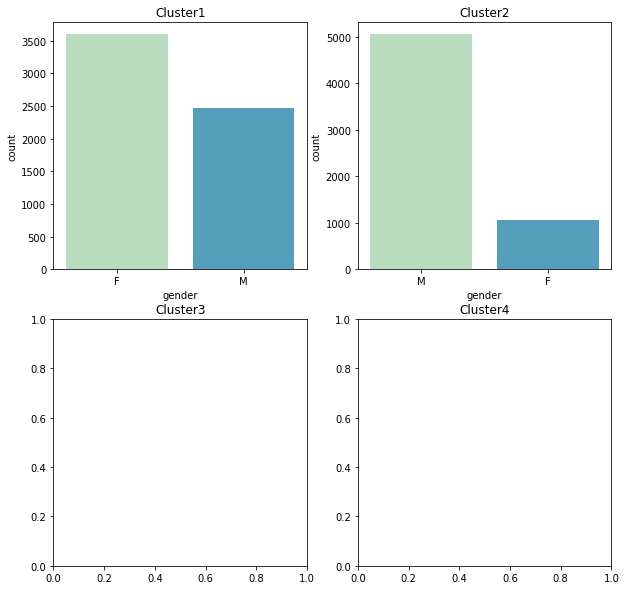

In [235]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.countplot(Cluster1.gender,palette='GnBu')
plt.title('Cluster1')
plt.subplot(222)
sns.countplot(Cluster2.gender,palette='GnBu')
plt.title('Cluster2')
plt.subplot(223) 
#sns.countplot(Cluster3.gender,palette='GnBu')
plt.title('Cluster3')
plt.subplot(224)
#sns.countplot(Cluster4.gender,palette='GnBu')
plt.title('Cluster4')

In [178]:
Cluster1.describe(include='all')

,gender,age,net,country,avg_pace,place_in_division,divisions,age_grp,clusters,pca1,pca2
count,9947,9947.000000,9947.000000,9947,9947.000000,9947,9947,9947.0,9947.0,9947.000000,9947.000000
unique,2,NaN,NaN,52,NaN,4472,17,12.0,NaN,NaN,NaN
top,F,NaN,NaN,USA,NaN,1411,4599,3.0,NaN,NaN,NaN
freq,5598,NaN,NaN,8950,NaN,5,4245,2323.0,NaN,NaN,NaN
mean,NaN,34.215945,274.228283,NaN,10.459143,NaN,NaN,NaN,0.0,-0.038107,0.000056
std,NaN,8.192144,53.847979,NaN,2.053777,NaN,NaN,NaN,0.0,0.024682,0.001970
min,NaN,18.000000,133.020000,NaN,5.073420,NaN,NaN,NaN,0.0,-0.114387,-0.002444
25%,NaN,28.000000,234.200000,NaN,8.932454,NaN,NaN,NaN,0.0,-0.055826,-0.001785
50%,NaN,33.000000,265.800000,NaN,10.137686,NaN,NaN,NaN,0.0,-0.034107,-0.000621
75%,NaN,40.000000,309.325000,NaN,11.797742,NaN,NaN,NaN,0.0,-0.017195,0.001944


In [179]:
Cluster2.describe(include='all')

,gender,age,net,country,avg_pace,place_in_division,divisions,age_grp,clusters,pca1,pca2
count,11629,11629.000000,11629.000000,11629,11629.000000,11629,11629,11629.0,11629.0,11629.000000,11629.000000
unique,2,NaN,NaN,58,NaN,2094,22,13.0,NaN,NaN,NaN
top,M,NaN,NaN,USA,NaN,1,2255,7.0,NaN,NaN,NaN
freq,8259,NaN,NaN,9043,NaN,22,1923,2970.0,NaN,NaN,NaN
mean,NaN,48.342162,244.414829,NaN,9.322050,NaN,NaN,NaN,1.0,0.032595,-0.000048
std,NaN,8.306342,39.599086,NaN,1.510320,NaN,NaN,NaN,0.0,0.026516,0.001904
min,NaN,20.000000,78.420000,NaN,2.990961,NaN,NaN,NaN,1.0,-0.002724,-0.003835
25%,NaN,43.000000,218.150000,NaN,8.320302,NaN,NaN,NaN,1.0,0.012309,-0.002539
50%,NaN,48.000000,241.100000,NaN,9.195621,NaN,NaN,NaN,1.0,0.027874,0.000690
75%,NaN,53.000000,268.030000,NaN,10.222739,NaN,NaN,NaN,1.0,0.047436,0.001262


In [180]:
Cluster3.describe(include='all')

,gender,age,net,country,avg_pace,place_in_division,divisions,age_grp,clusters,pca1,pca2
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unique,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
Cluster4.describe(include='all')

,gender,age,net,country,avg_pace,place_in_division,divisions,age_grp,clusters,pca1,pca2
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unique,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
